# Import Packages

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import xgboost as xgb
import pickle
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import random
from scipy.stats import bootstrap

# Read Data 

In [2]:
#read in original data without duplicates 
df = pd.read_csv('df_unique.csv')

In [3]:
#read in count vectorization data 
cv_data = pd.read_csv('cv_data.csv')

In [4]:
#combine the two dataframes to make it easier for qualitative analysis 
df_combined = pd.concat([df, cv_data], axis = 1)

In [5]:
#check out imbalance 
df_combined['bin_symptoms'].value_counts()

0    69765
1    10022
Name: bin_symptoms, dtype: int64

# Train-Val-Test Split

In [6]:
pt_ids, pt_lengths = np.unique(df_combined["pt_id"], return_counts=True)
# Set random seed for replicable result
random.seed(42)
# 0 for training, 1 for validation, 2 for testing
assignment = np.array(random.choices(population=[0, 1, 2], weights=[0.8, 0.1, 0.1], k=len(pt_ids)))

# Use randomized indices to split embeddings_df_combined dataset
train_idx   = [True if x == 0 else False for x in assignment]
val_idx     = [True if x == 1 else False for x in assignment]
test_idx    = [True if x == 2 else False for x in assignment]

train_pts = pt_ids[train_idx]
val_pts   = pt_ids[val_idx]
test_pts  = pt_ids[test_idx]

def train_val_test_split(x):
    if x in train_pts:
        return 0
    elif x in val_pts:
        return 1
    else:
        return 2

df_combined["assignment"] = df_combined['pt_id'].apply(train_val_test_split)

In [7]:
#split into train and test 
#since I'll be doing cross validation, there's no need to keep a separate validation
#however, we still keep the same testing set to ensure a fair comparison across models 
train_X = cv_data[df_combined["assignment"] != 2]
test_X  = cv_data[df_combined["assignment"] == 2]

train_y = df_combined[["bin_symptoms"]][df_combined["assignment"] != 2]
test_y  = df_combined[["bin_symptoms"]][df_combined["assignment"] == 2]

# Model

In [8]:
#a function for gridsearch with xgboost  
def run_xgb_binary(x_train, y_train, metric = 'roc_auc', max_depth = np.arange(2,4,1), learning_rate = [0.01, 0.05, 0.1], n_estimators = np.arange(200,350,50)):
    print('running gridsearch for xgb...')
    weight = sum(y_train['bin_symptoms'] == 0)/sum(y_train['bin_symptoms'] == 1)
    cv_folds = 3
    param_grid = {'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'n_estimators':n_estimators,
                 }
    
    est = xgb.XGBClassifier(verbosity=1, scale_pos_weight = weight)
    
    #grid search
    gs = GridSearchCV(estimator = est, 
                            param_grid=param_grid, 
                            scoring = metric, 
                            cv= cv_folds, 
                            verbose=1)
    gs.fit(x_train, y_train)
    print(gs.best_params_)

    return gs.best_estimator_

In [9]:
model_bin_orig = run_xgb_binary(train_X, train_y)

running gridsearch for xgb...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[22:44:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:44:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was change

[23:00:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

The code chunk above will also print the optimal parameters. The code below uses that set of optimal parameters and skips the gridsearch. This is so that I don't have to rerun the gridsearch every time.

In [10]:
#save model 
pickle.dump(model_bin_orig, open('xgb_bin.pkl', 'wb'))

In [11]:
#auc score
roc_auc_score(test_y, model_bin_orig.predict_proba(test_X)[:,1])

0.8055884570546311

In [12]:
#precision
precision_score(test_y, model_bin_orig.predict(test_X))

0.4290876242095754

In [13]:
#recall
recall_score(test_y, model_bin_orig.predict(test_X))

0.5562060889929742

In [14]:
#accuracy
(model_bin_orig.predict(test_X) == test_y['bin_symptoms']).mean()

0.8717493340098947

# Get Confidence Interval

In [6]:
model_bin_orig = pickle.load(open('xgb_bin.pkl', 'rb'))

In [16]:
#experimenting with different threshold levels
preds = model_bin_orig.predict_proba(test_X)[:,1]


In [17]:
np.save('y_preds_xgb_orig', preds)

In [18]:
functions = {
    'Accuracy': accuracy_score,
    'AUC': roc_auc_score,
    'Precision': precision_score,
    'Recall': recall_score
}

for name, func in functions.items():
    if name != 'AUC':
        res = bootstrap((test_y,preds > 0.5), func, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples = 1000)
    else:
        res = bootstrap((test_y,preds), func, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples = 1000)
    mid = (res.confidence_interval.high + res.confidence_interval.low)/2
    print( name + ': '+ str(round(mid[0], 2)) +  '+-' +  str(round(res.confidence_interval.high[0] - mid[0],2)))

Accuracy: 0.87+-0.01
AUC: 0.81+-0.02
Precision: 0.43+-0.03
Recall: 0.56+-0.03


# Shap Values

For XGBoost, analyzing feature importance is a bit tricky because the default feature importance attribute does not tell whether a word increases or decreases the probability of a certain prediction. Instead we can use SHAP plots.

In [19]:
import shap 
explainer = shap.Explainer(model_bin_orig)

In [20]:
shap_obj = explainer(train_X)

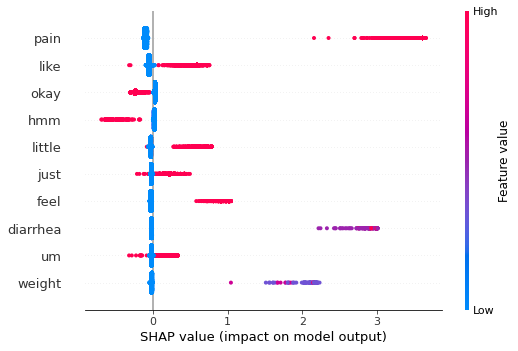

In [21]:
shap.summary_plot(shap_obj[:,:], max_display=10, feature_names = train_X.columns)

How to interpret SHAP plots: 
1. The y-axis indicates the variable name, in order of importance from top to 
bottom. The value next to them is the mean SHAP value.
2. On the x-axis is the SHAP value. Indicates how much is the change in log-odds per increment in the frequency of a particular word.

See this [link](https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/) for more info. 


# Qualitative Analysis

## Noise from original data 

Here are some examples of false negatives. Note that quite a few of these FN cases are difficult even for humans to identify as symptom-relevant, e.g. "But it’s, you know, it’s there, it’s there" and "I thought it was".

In [23]:
df_combined['pred'] = model_bin_orig.predict(cv_data)

In [ ]:
pd.set_option('max_colwidth', 2000)
df_combined.loc[(df_combined['bin_symptoms'] == 1) & (df_combined['pred'] == 0), 'turn_text'].head(10)

Also, there are cases where the label is negative but the text is clearly relevant to symptom talking. 

In [ ]:
df_combined.loc[(df_combined['_diarrhea_'] >= 1) & (df_combined['bin_symptoms'] == 0), 'turn_text']

## Noise from mapping

Part of the noise that we observe comes from mapping. Since machine does not understand contextual information, it simply maps the key phrases to symptoms whenever it sees any. For instance, 'breath' is one of the key words corresponding to the symptom 'shortness of breath', but it's sometimes mentioned during physical examinations or when the physician is trying to calmn the patient down. 

In [ ]:
df_combined.loc[(df_combined['_shortnessofbreath_'] >= 1) & (df_combined['avg_symptoms'] == 0), 'turn_text']